In [105]:
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [106]:
# LOAD VANE AND OBA DATA

df = pd.read_excel('csv/PrelimVaneTrapSamples.xlsx')
df = df.drop(index=148).reset_index(drop=True)

oba_data = pd.read_csv('csv/oba_bombus_cleaned.csv')
gdf = gpd.GeoDataFrame(
    oba_data,
    geometry=gpd.points_from_xy(oba_data['Dec. Long.'], oba_data['Dec. Lat.']),
    crs="EPSG:4326"
)

choice = "umpqua"

nf_gdf = gpd.read_file("map_data/National_Forest_Boundaries/National_Forest_Boundaries.shp")

if choice == 'umpqua':
    select_nfs = nf_gdf[nf_gdf['FORESTNAME'].isin(['Rogue River-Siskiyou National Forests', 'Umpqua National Forest', 'Willamette National Forest', 'Mt. Hood National Forest'])]
else:
    select_nfs = nf_gdf[nf_gdf['FORESTNAME'].isin(['Rogue River-Siskiyou National Forests', 'Umatilla National Forest', 'Willamette National Forest', 'Mt. Hood National Forest'])]
    
select_nfs = select_nfs.to_crs("EPSG:4326")

In [107]:
# MAPPING PREP

import geopandas as gpd
from shapely.geometry import Point
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from rasterio.warp import calculate_default_transform, reproject, Resampling

lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes', scale='110m')


def add_scale_bar(ax, length=100, location=(0, 0), linewidth=5, units='km', text=True):
    from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker
    import numpy as np
    import cartopy.crs as ccrs

    extent = ax.get_extent(crs=ccrs.PlateCarree())
    map_width_deg = extent[1] - extent[0]

    mid_lat = (extent[2] + extent[3]) / 2

    km_per_deg_at_lat = np.cos(np.radians(mid_lat)) * 111.32

    map_width_km = map_width_deg * km_per_deg_at_lat

    scale_bar_length_deg = (length / map_width_km) * map_width_deg
    
    x_start = location[0] * map_width_deg + extent[0]
    x_end = x_start + scale_bar_length_deg
    y_position = location[1] * (extent[3] - extent[2]) + extent[2]

    ax.plot([x_start, x_end], [y_position, y_position], transform=ccrs.PlateCarree(), color='k', linewidth=linewidth)
    
    if text==True:
        ax.text(x_end, y_position, ' '+f'{length} {units}', verticalalignment='bottom', horizontalalignment='left', transform=ccrs.Geodetic(), fontsize=10)

if choice == "umpqua":
    forest_colors = { # UMPQUA
        "Rogue River-Siskiyou National Forests": "#4C9A2A",
        "Umpqua National Forest": "#8C7A3E",
        "Willamette National Forest": "#A8CC6F",
        "Mt. Hood National Forest": "#49A874"
    }
else:
    forest_colors = { # UMATILLA
        "Rogue River-Siskiyou National Forests": "#4C9A2A",
        "Umatilla National Forest": "#8C7A3E",
        "Willamette National Forest": "#A8CC6F",
        "Mt. Hood National Forest": "#49A874"
    }

select_nfs["plot_color"] = select_nfs["FORESTNAME"].map(forest_colors)


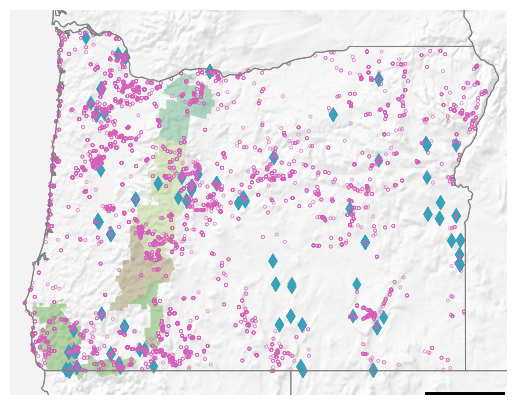

In [108]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_xlim(-124.8, -116.3)
ax.set_ylim(41.7, 46.45)

ax.add_feature(cfeature.COASTLINE, linewidth=.7, edgecolor='gray')
ax.add_feature(cfeature.STATES, linewidth=.7, edgecolor='gray')
ax.add_feature(lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

with rasterio.open('map_data/SR_HR.tif') as src:
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    ax.imshow(src.read(1), extent=extent, transform=ccrs.PlateCarree(), cmap='gray', alpha=0.2, zorder=0)

select_nfs.plot(
    ax=ax,
    facecolor=select_nfs["plot_color"],
    linewidth=0.8,
    alpha=0.4,
)

ax.scatter(df['Longitude'], df['Latitude'], transform=ccrs.PlateCarree(), marker='d', facecolors="#3BA0B9", edgecolors='none', lw=.8, s=60, alpha=1)
ax.scatter(gdf.geometry.x,gdf.geometry.y, transform=ccrs.PlateCarree(), marker='o', facecolors='none', edgecolors="#D661BB", lw=.4, s=5, alpha=1)

ax.axis('off')

add_scale_bar(ax=ax, length=100, location=(0.84,0), text=False)

plt.savefig('figs/oba_bvt_nf_umpqua.png', bbox_inches='tight', pad_inches=0, format='png', dpi=600)
# plt.savefig('figs/oba_bvt_nf_map.svg', bbox_inches='tight', pad_inches=0, format='svg', dpi=300)